In [6]:
# Set up
import sys
import os
from pathlib import Path

#project_root = os.path.abspath(os.path.join(os.getcwd(), '.'))
#if project_root not in sys.path:
    #sys.path.append(project_root)


# Insère en tête pour donner la priorité à votre code local
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Importation des modules nécessaires
import pandas as pd
import keras
from sklearn.preprocessing import StandardScaler

# Gestionnaire de données
from data.DataManager import DataManager

# Modèles de Deep Learning
from dl_models.MLPs import create_mlp_model,  LRHistory
from dl_models.CNNs import create_cnn_model
from dl_models.RNNs import LSTM, GRU, TKAN, create_rnn_model

# Métriques
from utils.metrics import compile_models_metrics, compute_estimators_metrics
from utils.visualization_tools import evaluate_and_plot
from utils.papers_runners import PaperEstimatorsRunner

from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error

In [7]:
keras.utils.set_random_seed(72)

# Nombre d'itération / taille de batch
N_MAX_EPOCH = 100
BATCH_SIZE = 32

# Liste de callbacks à utiliser dans les modèles
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience = 5,
        restore_best_weights=True
    ),

    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_loss",
        factor = 0.05,
        patience = 5,
        min_delta = 1e-6,
        verbose = 0
    ),

    LRHistory()
]

In [8]:
# Paramètres

# Définition des périodes de récupération
train_period: list = [(2023,7), (2023,8), (2023, 9), (2023,10)]
test_period: list = [(2023,11)]

# Choix lié à l'utilisation des indicateurs de dépendance sérielle
use_serial_dependance: bool = False

# Définition des actifs à récupérer
cryptos_train: list = ["ETHUSDT", "BNBUSDT", "XRPUSDT", "SOLUSDT", "ADAUSDT", "DOTUSDT"]
cryptos_test: list = ["MATICUSDT", "TRXUSDT"]

# Création du datamanager pour gérer les données d'entrainement + import
manager_train: DataManager = DataManager(symbols=cryptos_train, dates=train_period, light=True)
manager_train.download_and_prepare_data()

# Construction des features / labels pour les données d'entrainement
feature_paths = manager_train.load_features(use_serial_dependance)
labels_paths = manager_train.build_labels()

# Création du datamanager pour gérer les données de test (et import)
manager_test: DataManager = DataManager(symbols=cryptos_test, dates=test_period, light=True)
manager_test.download_and_prepare_data()

# Construction des features et labels pour les données de test
feature_paths_test = manager_test.load_features(use_serial_dependance)
labels_paths_test = manager_test.build_labels()


# Test dataframe de construction de test et val
X_train, X_val, y_train, y_val = manager_train.build_train_val_dataset()


# Construction des tests
X_test, y_test = manager_test.build_train_val_dataset(is_test=True)

# Normalisation des features
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# Normalisation des features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test).reshape(X_test.shape)

#Estimation papier
runner = PaperEstimatorsRunner(
    symbols = cryptos_test,          
    periods = [(2023, 11)] * len(cryptos_test), 
    mode    = "pair",
    light_download = True
)

df_est  = runner.get_estimates()
df_lab  = runner._load_labels_all()
df_all  = df_est.join(df_lab["spread_real"])
y_true  = df_all["spread_real"].values
paper_daily = df_all.drop(columns="spread_real")


Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-1m-2023-07.parquet
BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-bookTicker-2023-07.parquet
Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-1m-2023-08.parquet
BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-bookTicker-2023-08.parquet
Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-1m-2023-09.parquet
BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-bookTicker-2023-09.parquet
Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw da

## CNN

TRAIN CNN : (576, 1440, 15) (576, 1)
TRAIN CNN : (144, 1440, 15) (144, 1)
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 149.7675 - val_loss: 1.4347
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.1200 - val_loss: 0.6041
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9046 - val_loss: 0.5812
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9152 - val_loss: 0.5804
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9048 - val_loss: 0.5828
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8880 - val_loss: 0.5862
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8945 - val_loss: 0.5894
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8529 - val_loss: 0.5949
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8560 - val_loss: 0.5978
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8319 - val_loss: 0.6084
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.

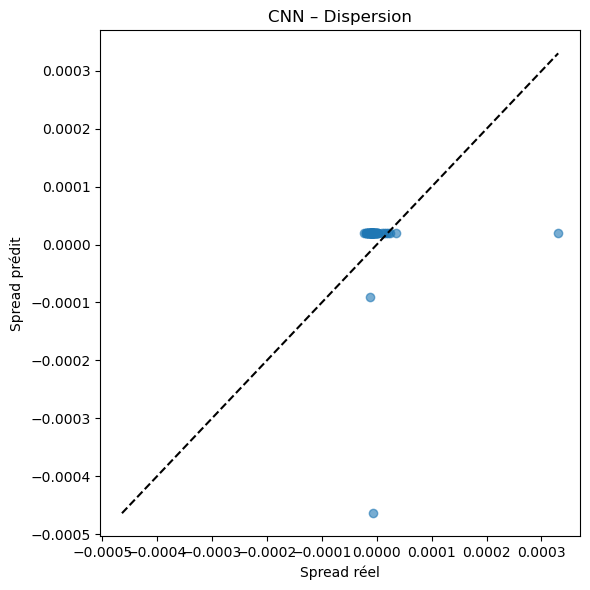

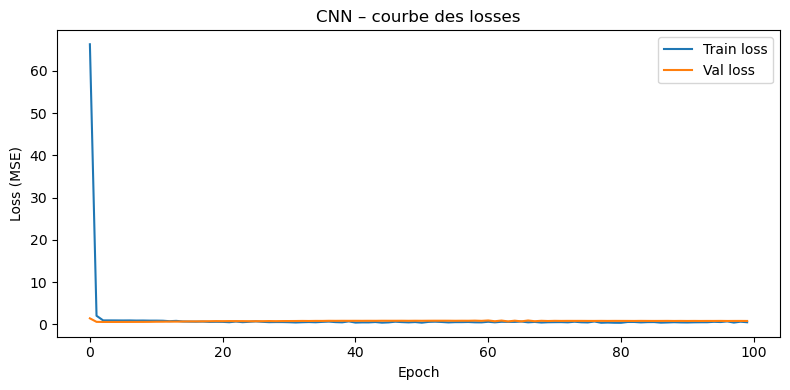

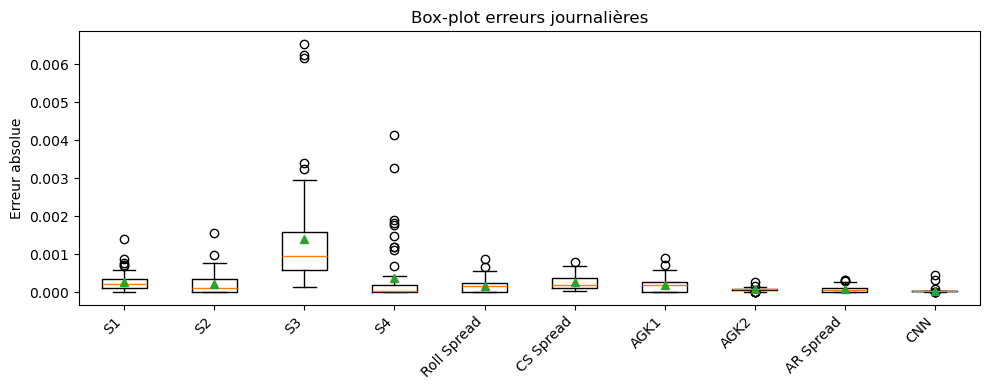

,R²,RMSE,MAE
S1,-66.113826,0.000364,0.000266
S2,-61.568235,0.000351,0.000209
S3,-1959.405112,0.001966,0.001410
S4,-379.882029,0.000866,0.000363
Roll Spread,-29.063286,0.000243,0.000167
CS Spread,-53.249058,0.000327,0.000269
AGK1,-33.907995,0.000262,0.000182
AGK2,-2.536338,0.000083,0.000073
AR Spread,-7.356203,0.000128,0.000088
CNN,NaN,0.000077,0.000039


,R²,RMSE,MAE
S1,-66.113826,0.000364,0.000266
S2,-61.568235,0.000351,0.000209
S3,-1959.405112,0.001966,0.001410
S4,-379.882029,0.000866,0.000363
Roll Spread,-29.063286,0.000243,0.000167
CS Spread,-53.249058,0.000327,0.000269
AGK1,-33.907995,0.000262,0.000182
AGK2,-2.536338,0.000083,0.000073
AR Spread,-7.356203,0.000128,0.000088
CNN,NaN,0.000077,0.000039


In [9]:

# Train CNN
X_tr_cnn, y_tr_cnn = manager_train.format_data(
    X_train_scaled, y_train_scaled,
    model_type='cnn',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TRAIN CNN :", X_tr_cnn.shape, y_tr_cnn.shape)

X_val_cnn, y_val_cnn = manager_train.format_data(
    X_val_scaled, y_val_scaled,
    model_type='cnn',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TRAIN CNN :", X_val_cnn.shape, y_val_cnn.shape)


# Création et entraînement du CNN
input_shape = X_tr_cnn.shape[1:]     # (1440, 11)
cnn = create_cnn_model(input_shape=input_shape, model_type="simple",output_activation='linear')
cnn.compile(optimizer='adam', loss='mse')

history = cnn.fit(
    X_tr_cnn, y_tr_cnn,
    validation_data=(X_val_cnn, y_val_cnn),
    epochs=N_MAX_EPOCH,
    batch_size=BATCH_SIZE,
    verbose=1,
    #callbacks=callbacks
)

# Formatage des features de test
X_te_cnn, y_te_cnn = manager_test.format_data(
    X_test_scaled,
    y_test_scaled,
    model_type='cnn',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TEST CNN :", X_te_cnn.shape, y_te_cnn.shape)

# Test sur CNN
# Make predictions with MLP
y_pred_cnn_train = cnn.predict(X_tr_cnn)
y_pred_cnn_test = cnn.predict(X_te_cnn)

# Compute metrics for MLP
cnn_mse_train = mean_squared_error(y_tr_cnn, y_pred_cnn_train)
cnn_mse_test = mean_squared_error(y_te_cnn, y_pred_cnn_test)
cnn_r2_train = r2_score(y_tr_cnn, y_pred_cnn_train)
cnn_r2_test = r2_score(y_te_cnn, y_pred_cnn_test)


# Métriques (toutes)
df_perf = runner.evaluate()


evaluate_and_plot(
    model          = cnn,
    X              = X_te_cnn,
    y              = y_te_cnn,
    scaler_y       = scaler_y,
    title          = "CNN",
    history        = history,        
    paper_daily    = paper_daily, 
    paper_metrics  = df_perf ,   
    y_true_daily   = y_true,         
)






## MLP

TRAIN MLP : (576, 21600) (576, 1)
Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.3888 - val_loss: 5.1145
Epoch 2/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 11.6782 - val_loss: 13.5742
Epoch 3/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 15.2573 - val_loss: 12.3383
Epoch 4/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 42.8883 - val_loss: 5.2831
Epoch 5/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 59.5527 - val_loss: 4.9319
Epoch 6/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.7743 - val_loss: 21.9232
Epoch 7/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 14.7864 - val_loss: 34.6914
Epoch 8/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12.6956 - val_loss: 12.0432
Epoch 9/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 14.6564 - val_loss: 20.0954
Epoch 10/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 15.4421 - val_loss: 8.2693
Epoch 11/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 11.3470 - val_loss: 24.4304
Epoch 12/60
1

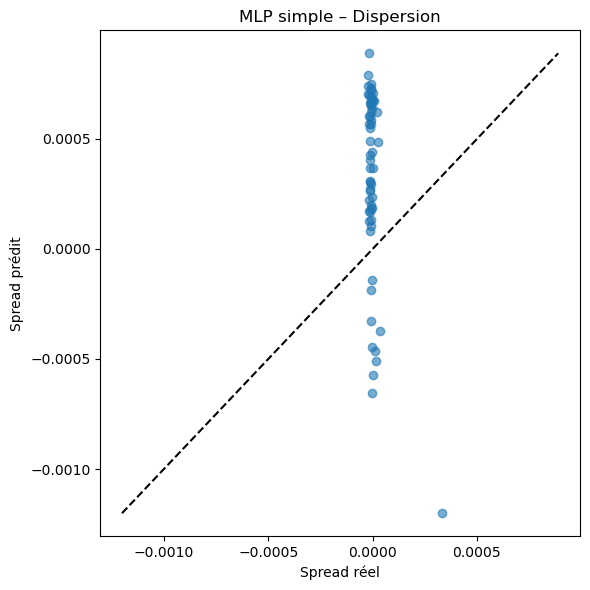

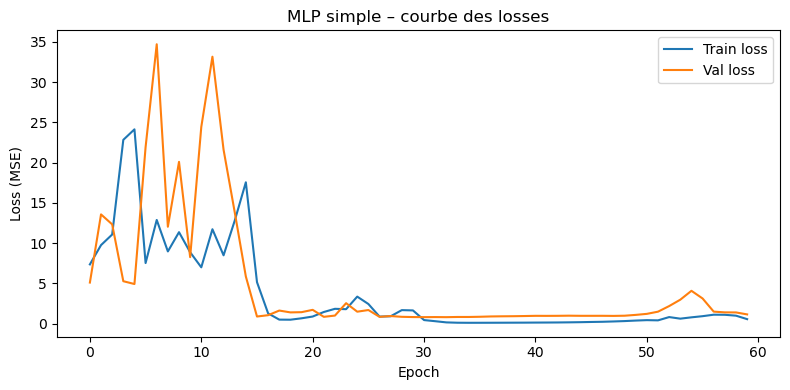

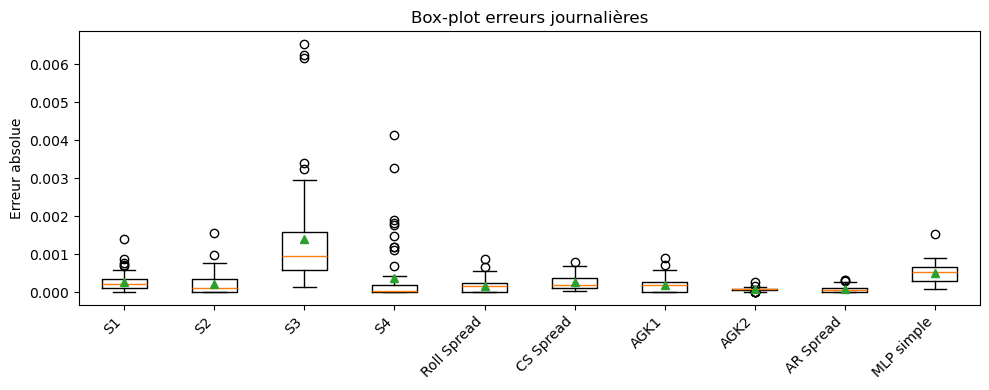

,R²,RMSE,MAE
S1,-66.113826,0.000364,0.000266
S2,-61.568235,0.000351,0.000209
S3,-1959.405112,0.001966,0.001410
S4,-379.882029,0.000866,0.000363
Roll Spread,-29.063286,0.000243,0.000167
CS Spread,-53.249058,0.000327,0.000269
AGK1,-33.907995,0.000262,0.000182
AGK2,-2.536338,0.000083,0.000073
AR Spread,-7.356203,0.000128,0.000088
MLP simple,NaN,0.000561,0.000501


,R²,RMSE,MAE
S1,-66.113826,0.000364,0.000266
S2,-61.568235,0.000351,0.000209
S3,-1959.405112,0.001966,0.001410
S4,-379.882029,0.000866,0.000363
Roll Spread,-29.063286,0.000243,0.000167
CS Spread,-53.249058,0.000327,0.000269
AGK1,-33.907995,0.000262,0.000182
AGK2,-2.536338,0.000083,0.000073
AR Spread,-7.356203,0.000128,0.000088
MLP simple,NaN,0.000561,0.000501


In [10]:

# Mise en forme des données pour le MLP
X_tr_mlp, y_tr_mlp = manager_train.format_data(
    X_train_scaled, y_train_scaled,
    model_type='mlp',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TRAIN MLP :", X_tr_mlp.shape, y_tr_mlp.shape)


# Construction et entraînement du modèle MLP
input_shape = X_tr_mlp.shape
mlp = create_mlp_model(
    input_shape=input_shape,
    model_type="simple",
    hidden_dims=[128, 64, 32],
    output_activation  = "linear"
)
mlp.compile(optimizer='adam', loss='mse')

history_mlp = mlp.fit(
    X_tr_mlp, y_tr_mlp,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    verbose=1,
    #callbacks=callbacks
)

#Préparation du set de test au même format
X_te_mlp, y_te_mlp = manager_test.format_data(
    X_test_scaled, y_test_scaled,
    model_type='mlp',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TEST  MLP :", X_te_mlp.shape, y_te_mlp.shape)


evaluate_and_plot(
    model          = mlp,
    X              = X_te_mlp,
    y              = y_te_mlp,
    scaler_y       = scaler_y,
    title          = "MLP simple",
    history        = history_mlp,      
    paper_daily    = paper_daily, 
    paper_metrics  = df_perf ,            
    y_true_daily   = y_true,          
)


## RNN LSTM

In [ ]:
#########################################################################
# 1. Mise en forme TRAIN / VAL pour le RNN (ici LSTM)
#########################################################################
X_tr_rnn, y_tr_rnn = manager_train.format_data(
    X_train_scaled, y_train_scaled,
    model_type='rnn',      # (nb_days, 1440, n_feat)
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
X_val_rnn, y_val_rnn = manager_train.format_data(
    X_val_scaled, y_val_scaled,
    model_type='rnn',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TRAIN RNN :", X_tr_rnn.shape, y_tr_rnn.shape)
print("VAL   RNN :", X_val_rnn.shape, y_val_rnn.shape)


input_shape = X_tr_rnn.shape[1:]           # (1440, n_feat)
rnn = create_rnn_model(
    input_shape = input_shape,
    nb_assets   = 1,
    rnn_layer   = LSTM(units=100, return_sequences=False, dropout=0.2),
    use_conv    = False
)
rnn.compile(optimizer='adam', loss='mse')

history_rnn = rnn.fit(
    X_tr_rnn, y_tr_rnn,
    validation_data = (X_val_rnn, y_val_rnn),
    epochs          = 60,
    batch_size      = 32,
    verbose         = 1,
    callbacks       = callbacks
)

#########################################################################
# 3. Préparation du JEU DE TEST
#########################################################################
X_te_rnn, y_te_rnn = manager_test.format_data(
    X_test_scaled, y_test_scaled,
    model_type='rnn',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TEST RNN :", X_te_rnn.shape, y_te_rnn.shape)

#########################################################################
# 4. Évaluation + visualisation + comparaison papier
#########################################################################
df_compare_rnn = evaluate_and_plot(
    model          = rnn,
    X              = X_te_rnn,
    y              = y_te_rnn,
    scaler_y       = scaler_y,
    title          = "LSTM – actifs de test",
    history        = history_rnn,
    paper_metrics  = df_perf,     # tableaux agrégés (RMSE / MAE / R² / Score)
    paper_daily    = paper_daily,    # valeurs journalières des estimateurs papier
    y_true_daily   = y_true
)


display(df_compare_rnn)


## RNN GRU

TRAIN GRU : (576, 1440, 15) (576, 1)

Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1031s 20s/step - loss: 1.7385 - mae: 0.7821 - val_loss: 0.8069 - val_mae: 0.5430 - learning_rate: 0.0010
Epoch 2/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 178s 12s/step - loss: 1.4455 - mae: 0.6511 - val_loss: 0.8345 - val_mae: 0.5246 - learning_rate: 0.0010
Epoch 3/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 179s 12s/step - loss: 1.3705 - mae: 0.6219 - val_loss: 0.7184 - val_mae: 0.4686 - learning_rate: 0.0010
Epoch 4/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 180s 12s/step - loss: 1.2912 - mae: 0.5644 - val_loss: 0.7221 - val_mae: 0.4711 - learning_rate: 0.0010
Epoch 5/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 175s 12s/step - loss: 1.2069 - mae: 0.5209 - val_loss: 0.7403 - val_mae: 0.4730 - learning_rate: 0.0010
Epoch 6/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 178s 12s/step - loss: 1.1751 - mae: 0.5008 - val_loss: 0.7421 - val_mae: 0.4805 - learning_rate: 0.0010
Epoch 7/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 184s 12s/step - loss: 1.1500 - mae: 0.4695 - val_loss: 0.7570 - val_mae

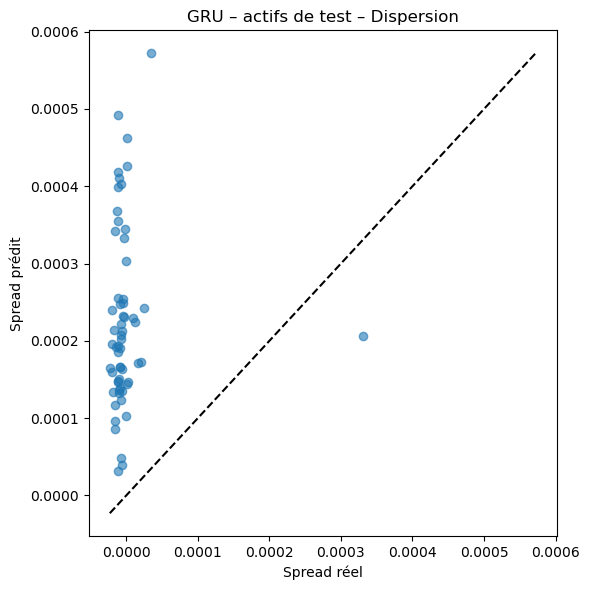

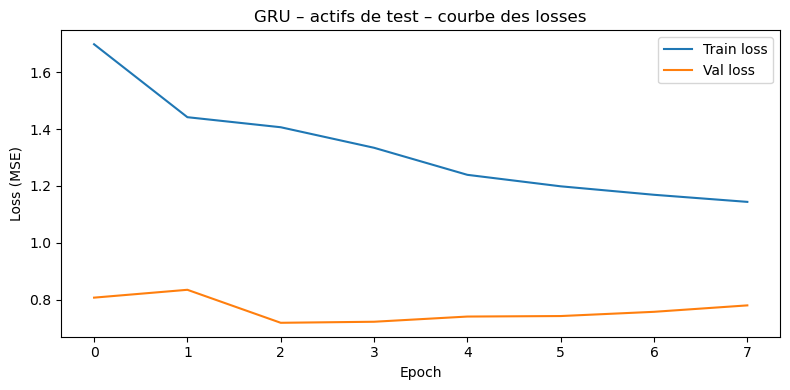

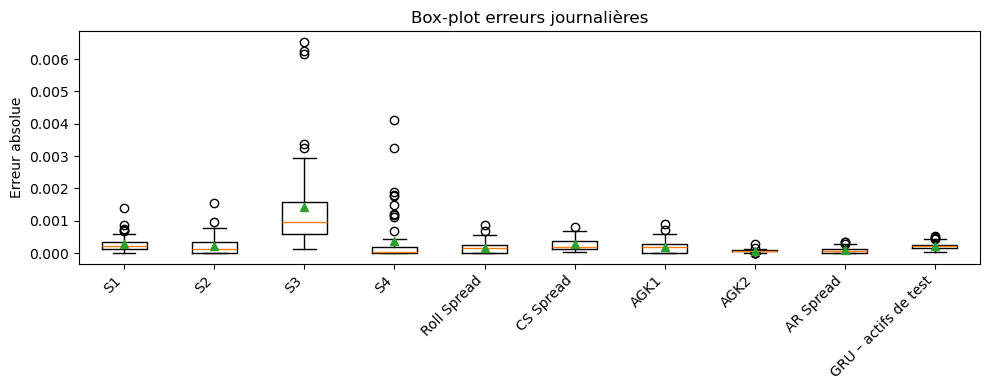

,R²,RMSE,MAE
S1,-66.113826,0.000364,0.000266
S2,-61.568235,0.000351,0.000209
S3,-1959.405112,0.001966,0.001410
S4,-379.882029,0.000866,0.000363
Roll Spread,-29.063286,0.000243,0.000167
CS Spread,-53.249058,0.000327,0.000269
AGK1,-33.907995,0.000262,0.000182
AGK2,-2.536338,0.000083,0.000073
AR Spread,-7.356203,0.000128,0.000088
GRU – actifs de test,NaN,0.000256,0.000230


,R²,RMSE,MAE
S1,-66.113826,0.000364,0.000266
S2,-61.568235,0.000351,0.000209
S3,-1959.405112,0.001966,0.001410
S4,-379.882029,0.000866,0.000363
Roll Spread,-29.063286,0.000243,0.000167
CS Spread,-53.249058,0.000327,0.000269
AGK1,-33.907995,0.000262,0.000182
AGK2,-2.536338,0.000083,0.000073
AR Spread,-7.356203,0.000128,0.000088
GRU – actifs de test,NaN,0.000256,0.000230


In [11]:
X_tr_gru, y_tr_gru = manager_train.format_data(
    X_train_scaled, y_train_scaled,
    model_type='rnn',          # → (nb_days, 1440, n_feat)
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)

print("TRAIN GRU :", X_tr_gru.shape, y_tr_gru.shape)

input_shape = X_tr_gru.shape[1:]   # (1440, n_feat)
gru_model = create_rnn_model(
    input_shape = input_shape,
    nb_assets   = 1,
    rnn_layer   = GRU(units=100, return_sequences=False, dropout=0.3),
    use_conv    = False
)

gru_model.compile(optimizer='adam', loss='mse')

history_gru = gru_model.fit(
    X_tr_gru, y_tr_gru,
    validation_split=0.2,
    epochs          = 60,
    batch_size      = 32,
    verbose         = 1,
    callbacks       = callbacks          
)

X_val_gru, y_val_gru = manager_train.format_data(
    X_val_scaled, y_val_scaled,
    model_type='rnn',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)

print("VAL   GRU :", X_val_gru.shape, y_val_gru.shape)

X_te_gru, y_te_gru = manager_test.format_data(
    X_test_scaled, y_test_scaled,
    model_type='rnn',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TEST GRU :", X_te_gru.shape, y_te_gru.shape)

df_compare_gru = evaluate_and_plot(
    model          = gru_model,
    X              = X_te_gru,
    y              = y_te_gru,
    scaler_y       = scaler_y,
    title          = "GRU – actifs de test",
    history        = history_gru,
    paper_metrics  = df_perf,     
    paper_daily    = paper_daily,    
    y_true_daily   = y_true
)


display(df_compare_gru)

## RNN TKAN

TRAIN TKAN : (571, 5, 21600) (571, 1)
Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 1.8675 - mae: 0.5523 - val_loss: 0.7651 - val_mae: 0.3496 - learning_rate: 0.0010
Epoch 2/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.7875 - mae: 0.3207 - val_loss: 0.7652 - val_mae: 0.3497 - learning_rate: 0.0010
Epoch 3/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.7852 - mae: 0.3197 - val_loss: 0.7741 - val_mae: 0.3655 - learning_rate: 0.0010
Epoch 4/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.7748 - mae: 0.3301 - val_loss: 0.7759 - val_mae: 0.3622 - learning_rate: 0.0010
Epoch 5/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.7718 - mae: 0.3205 - val_loss: 0.7652 - val_mae: 0.3499 - learning_rate: 0.0010
Epoch 6/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.7879 - mae: 0.3211 - val_loss: 0.7652 - val_mae: 0.3499 - learning_rate: 0.0010
VAL   TKAN : (139, 5, 21600) (139, 1)
TEST TKAN : (55, 5, 21600) (55, 1)
TKAN – actifs de test – Test | RMSE=0

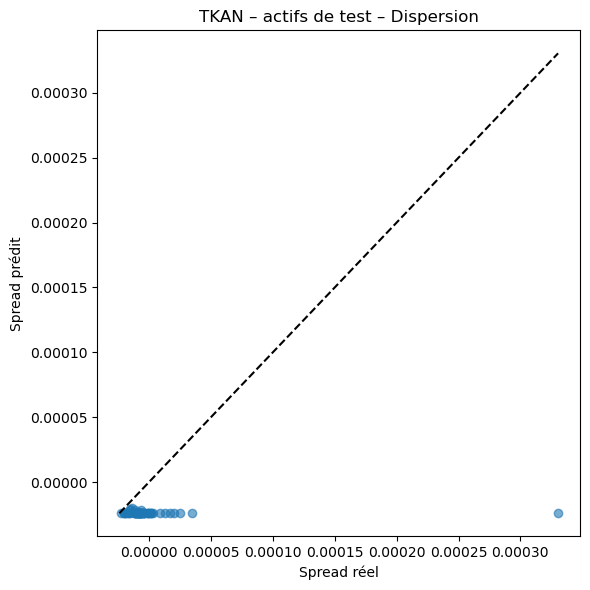

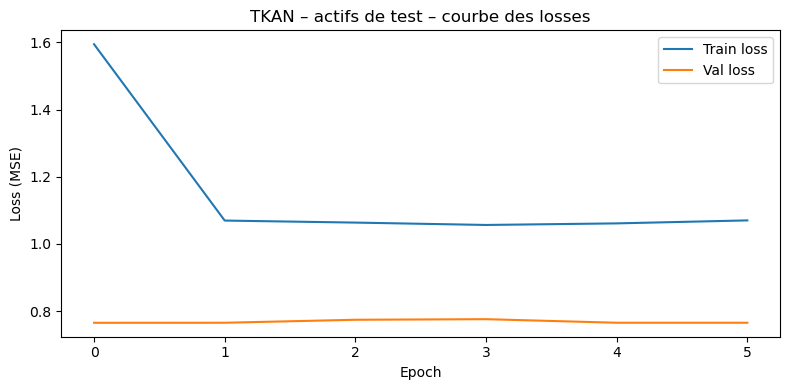

ValueError: operands could not be broadcast together with shapes (55,) (60,) 

In [12]:
WINDOW = 5          # nombre de jours d’historique vus par la séquence

X_tr_tkan, y_tr_tkan = manager_train.format_data(
    X_train_scaled, y_train_scaled,
    model_type='seq',          
    daily=False,
    nb_assets=1,
    minutes_per_day=1440,
    window=WINDOW
)

print("TRAIN TKAN :", X_tr_tkan.shape, y_tr_tkan.shape)

input_shape = X_tr_tkan.shape[1:]   
tkan_model  = create_rnn_model(
    input_shape = input_shape,
    nb_assets   = 1,
    rnn_layer   = TKAN(units=100, num_heads=4, return_sequences=False),
    use_conv    = False
)
tkan_model.compile(optimizer='adam', loss='mse')

history_tkan = tkan_model.fit(
    X_tr_tkan, y_tr_tkan,
    validation_split=0.2,
    epochs          = 60,
    batch_size      = 32,
    verbose         = 1,
    callbacks       = callbacks
)

X_val_tkan, y_val_tkan = manager_train.format_data(
    X_val_scaled, y_val_scaled,
    model_type='seq',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440,
    window=WINDOW
)

print("VAL   TKAN :", X_val_tkan.shape, y_val_tkan.shape)

X_te_tkan, y_te_tkan = manager_test.format_data(
    X_test_scaled, y_test_scaled,
    model_type='seq',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440,
    window=WINDOW
)

print("TEST TKAN :", X_te_tkan.shape, y_te_tkan.shape)

df_compare_tkan = evaluate_and_plot(
    model          = tkan_model,
    X              = X_te_tkan,
    y              = y_te_tkan,
    scaler_y       = scaler_y,
    title          = "TKAN – actifs de test",
    history        = history_tkan,
    paper_metrics  = df_perf,   
    paper_daily    = paper_daily,   
    y_true_daily   = y_true
)


display(df_compare_tkan)